# Exploring the OSHA chemical monitoring dataset
### Author: Jeff Minucci
### Date: 9/9/2019

In [1]:
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tabulate import tabulate
from numba import jit
%matplotlib inline

Using matplotlib backend: Qt5Agg


### Load the dataset

In [2]:
if not '../data/osha/osha_monitoring_1984_2018.csv':
    with zipfile.ZipFile('../data/osha/osha_monitoring_1984_2018.zip','r') as zfile:
        zfile.extractall('../data/osha')
osha = pd.read_csv('../data/osha/osha_monitoring_1984_2018.csv', dtype={'naics_code':pd.Int32Dtype(), 'sic_code':pd.Int32Dtype()})

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,8,12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(osha[osha['sample_type'].isin(['W'])])

196297

### Load data on physio-chemical properties and molecular fingerprints of the chemicals sampled

In [5]:
chem_data = pd.read_csv('../data/osha/osha_chem_properties.csv')
chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
chem_data.columns = [x.lower() for x in chem_data.columns]

### Clean and organize the data

In [6]:
osha.drop(osha.columns[0], axis=1, inplace=True)  # drop first column of old indices
osha['imis_substance_code'] = osha['imis_substance_code'].astype('category')
osha['sample_result'] = pd.to_numeric(osha['sample_result'], errors='coerce')
osha['air_volume_sampled'] = pd.to_numeric(osha['air_volume_sampled'], errors='coerce')

# keep only samples with units of concentration, or that we can convert to concentrations
osha = osha[osha['unit_of_measurement'].isin(['M', 'P', "%"]) | ((osha['unit_of_measurement'].isin(['X', 'Y'])) & osha['air_volume_sampled']>0)]

# keep only  sample types P=personal, A=area, B=bulk
osha = osha[osha['sample_type'].isin(['P','A', 'B'])]

# add average mol mass of the substances
osha = osha.merge(chem_data[['input', 'average_mass', 'preferred_name']], left_on='substance', right_on='input')
osha = osha[osha['preferred_name'] != '-']

#drop rows with measurements that are NaN or Inf
osha = osha[np.isfinite(osha.sample_result)]

In [7]:
len(osha)

1309640

Convert all units to mg/m3

In [8]:
# convert all units to mg/m3
@jit(parallel=True, forceobj=True)
def convert_mg_m3(result, units, air_vol, mol_wt):
    n = len(result)
    concentrations = np.empty(n)
    for i in range(n):
        unit = units[i]
        x = result[i]
        vol = air_vol[i]
        mw = mol_wt[i]
        if unit == 'Y': # mg
            val = x/(vol*0.001)
        elif unit == 'X': # mcg
            val = (x/1000)/(vol*0.001)
        elif unit == '%': # percent
            val = (x*10000) * mw/24.45  # based on 25C and 1 atm
        elif unit == 'P':  
            val = x * mw/24.45  # based on 25C and 1 atm
        else:
            val = x
        concentrations[i] = val
    return concentrations

osha['conc_mgm3'] = convert_mg_m3(osha['sample_result'].to_numpy(), osha['unit_of_measurement'].to_numpy(dtype=str),
                                  osha['air_volume_sampled'].to_numpy(), osha['average_mass'].to_numpy())

osha = osha.drop(osha[osha['qualifier'].str.contains('BLK', na=False)].index)  # drop blanks
osha['conc_mgm3'] = np.where(osha['qualifier'].str.contains('ND',na=False), 0, osha['conc_mgm3'])  # if non-detect, set conc to 0

#write unit converted dataset to file
osha.to_csv('../data/osha/osha_normalized.csv')

### How many substances are in the raw OSHA monitoring dataset?

In [9]:
osha.preferred_name.describe()

count     1265341
unique        932
top          Lead
freq       117026
Name: preferred_name, dtype: object

In [10]:
thresholds = [2,10,50,100,500,1000, 5000, 10000]
counts = []
sub_counts = osha.imis_substance_code.value_counts()
for x in thresholds:
    counts.append(len(sub_counts[sub_counts >= x]))
print(tabulate({'Num of occurrences':thresholds, 'Num of substances':counts}, headers = 'keys', tablefmt='psql'))

+----------------------+---------------------+
|   Num of occurrences |   Num of substances |
|----------------------+---------------------|
|                    2 |                 892 |
|                   10 |                 583 |
|                   50 |                 342 |
|                  100 |                 251 |
|                  500 |                 126 |
|                 1000 |                  90 |
|                 5000 |                  35 |
|                10000 |                  23 |
+----------------------+---------------------+


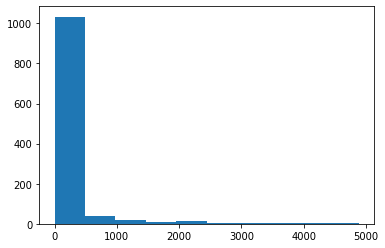

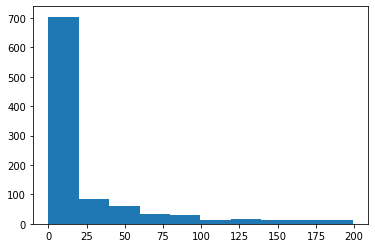

Median # of occurrences in osha monitoring: 10


In [11]:
sub_counts[sub_counts < 5000].hist(grid=False)
plt.show()
sub_counts[sub_counts < 200].hist(grid=False)
plt.show()
print('Median # of occurrences in osha monitoring: {:.0f}'.format(np.median(sub_counts)))

### Let's aggregate by the average detected concentration for each chemical and match to chemical properties

Aggregate mean concentrations by substance, also grouping by sampling #

In [ ]:
osha_agg = osha.groupby(['sampling_number','preferred_name']).mean().groupby('preferred_name').mean().reset_index()[['preferred_name','conc_mgm3']]

In [ ]:
print(len(osha_agg),len(osha_agg[np.isfinite(osha_agg.conc_mgm3)]))
osha_agg = osha_agg[np.isfinite(osha_agg.conc_mgm3)]

Merge our data on physio-chemical properties and molecular fingerprints

In [ ]:
osha_agg = osha_agg.merge(chem_data[chem_data.columns.difference(['average_mass','input','found_by','found_by_search'])], 
                          left_on='preferred_name', right_on='preferred_name')
osha_agg = osha_agg.drop_duplicates()
osha_agg.to_csv('../data/osha/osha_means.csv')

In [ ]:
#osha = osha.merge(chem_data[chem_data.columns.difference(['average_mass'])], left_on='substance', right_on='input')
#osha.to_csv('data/osha/osha_add_features.csv')

### Also make a dataset where we use the peak concentration from each sampling effort

In [ ]:
osha_agg_max = osha.groupby(['sampling_number','preferred_name']).max().groupby('preferred_name').mean().reset_index()[['preferred_name','conc_mgm3']]
osha_agg_max = osha_agg_max[np.isfinite(osha_agg_max.conc_mgm3)]

In [ ]:
osha_agg_max = osha_agg_max.merge(chem_data[chem_data.columns.difference(['average_mass','input','found_by','found_by_search'])], 
                          left_on='preferred_name', right_on='preferred_name')
osha_agg_max = osha_agg_max.drop_duplicates()
osha_agg_max.to_csv('../data/osha/osha_mean_peak.csv')

### Make a dataset for the probability of detection

In [ ]:
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)

In [ ]:
osha['detected'].head()

In [ ]:
prob_subset = osha.loc[:,['sampling_number', 'preferred_name', 'detected']].copy()
osha_prob = prob_subset.groupby(['sampling_number','preferred_name']).max().groupby('preferred_name').mean().reset_index()[['preferred_name','detected']]
osha_prob.rename(columns={'detected': 'prob_detection'}, inplace=True)
osha_prob = osha_prob[np.isfinite(osha_prob.prob_detection)]

In [ ]:
osha_prob = osha_prob.merge(chem_data[chem_data.columns.difference(['average_mass','input','found_by','found_by_search'])], 
                          left_on='preferred_name', right_on='preferred_name')
osha_prob = osha_prob.drop_duplicates()
osha_prob.to_csv('../data/osha/osha_probs.csv')

Aggregating by inspection number instead of sampling effort

In [ ]:
prob_subset2 = osha.loc[:,['inspection_number', 'preferred_name', 'detected']].copy()
osha_prob2 = prob_subset2.groupby(['inspection_number','preferred_name']).max().groupby('preferred_name').mean().reset_index()[['preferred_name','detected']]
osha_prob2.rename(columns={'detected': 'prob_detection'}, inplace=True)
osha_prob2 = osha_prob2[np.isfinite(osha_prob2.prob_detection)]
osha_prob2 = osha_prob2.merge(chem_data[chem_data.columns.difference(['average_mass','input','found_by','found_by_search'])], 
                          left_on='preferred_name', right_on='preferred_name')
osha_prob2 = osha_prob2.drop_duplicates()
osha_prob2.to_csv('../data/osha/osha_probs_inspection.csv')

### Make a dataset of detects/nondetects for every sampling effort 

In [ ]:
osha_detect = prob_subset.groupby(['sampling_number','preferred_name']).max().reset_index()[['preferred_name','detected']]
osha_detect = osha_detect[np.isfinite(osha_prob.prob_detection)]

In [ ]:
osha_detect = osha_detect.merge(chem_data[chem_data.columns.difference(['average_mass','input','found_by','found_by_search'])], 
                          left_on='preferred_name', right_on='preferred_name')
#osha_detect = osha_detect.drop_duplicates()
osha_detect.to_csv('../data/osha/osha_detects.csv')